In [1]:
from functools import partial

import jax
import jax.lax as lax
import jax.numpy as jnp
import jax.random as jrng 

from jax import Array

import matplotlib.pyplot as plt

jnp.set_printoptions(precision=3)

In [2]:
seed = 0
n = 4 # Number of states
m = 3 # Number of observations

key = jrng.key(seed)
key, O_key, mu_key = jrng.split(key, 3)

# Construct a transition matrix that stays in the same state with 99% probability and transitions to the next with 1%
T = 0.99 * jnp.eye(n)
T = T + 0.01 * jnp.eye(n, k=1)
T = T / jnp.sum(T, axis=-1)[:,None]

# Construct an initial state distribution where the earlier states are more likely
mu = jnp.exp(- 5 * jnp.arange(0, n))
mu = mu.at[n -1].set(0)
mu = mu / jnp.sum(mu)

# Construct a noisy observation matrix
O = jrng.uniform(O_key, (n, m))
O = O * jnp.linspace(0, 1, n)[:, None]
for s in range(n):
    O = O.at[s, (s * m) // n ].set(.5)
O = O.at[n-1].set(0.0)
O = O.at[n-1, m-1].set(1.0)
O = O / jnp.sum(O, axis=-1)[:,None]

print("T row sums:", jnp.sum(T, axis=-1), 
      "\nO row sums:", jnp.sum(O, axis=-1), 
      "\nmu sum:", jnp.sum(mu)[None])

T row sums: [1. 1. 1. 1.] 
O row sums: [1. 1. 1. 1.] 
mu sum: [1.]


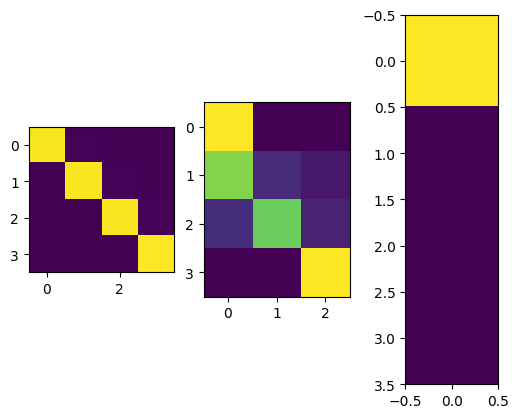

In [3]:
fix, ax = plt.subplots(1, 3)

ax[0].imshow(T)
ax[1].imshow(O)
ax[2].imshow(mu[:,None])
plt.show()

In [4]:
@partial(jax.jit, static_argnames="length")
def generate_sequence(
        key: Array,
        transition_matrix: Array, 
        observation_matrix: Array, 
        initial_distribution: Array, 
        length: int) -> Array:

    n, m = observation_matrix.shape

    all_states = jnp.arange(0, n, dtype=int)
    all_observations = jnp.arange(0, m, dtype=int)

    initial_key, *key_array = jrng.split(key, 1 + length)
    initial_state = jrng.categorical(initial_key, initial_distribution)

    def step(state, sampling_key):
        obs_key, state_key = jrng.split(sampling_key)

        observation = jrng.choice(obs_key, all_observations, p=observation_matrix[state])
        next_state = jrng.choice(state_key, all_states, p=transition_matrix[state])

        return next_state, (state, observation)
    
    _, (states, observations) = lax.scan(step, initial_state, jnp.array(key_array))

    return states, observations



In [5]:
n_sequences = 1000
len_sequence = 2000
key, *sequence_keys = jrng.split(key, 1 + n_sequences)

result = jax.vmap(lambda _key: generate_sequence(_key, T, O, mu, len_sequence))(jnp.array(sequence_keys))

In [6]:
states, observations = result
states.shape

(1000, 2000)

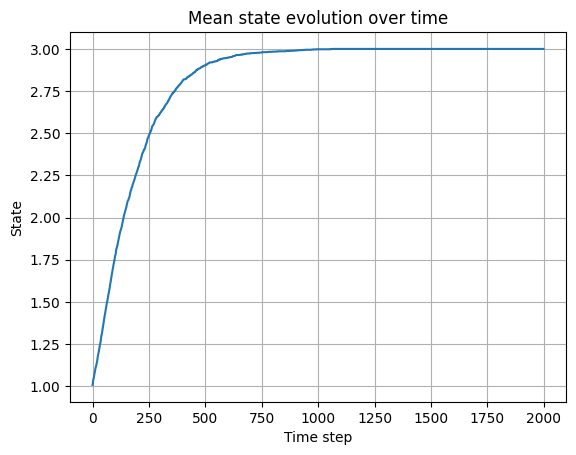

In [7]:
plt.title("Mean state evolution over time")
plt.plot(jnp.mean(states, axis=0))
plt.grid()
plt.xlabel("Time step")
plt.ylabel("State")
plt.show()

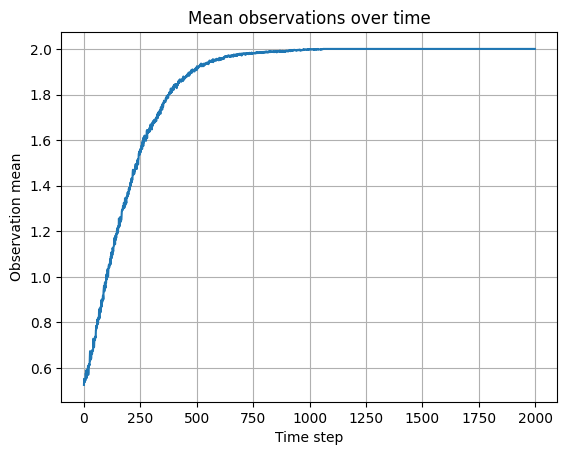

In [8]:
plt.title("Mean observations over time")
plt.plot(jnp.mean(observations, axis=0))
plt.grid()
plt.xlabel("Time step")
plt.ylabel("Observation mean")
plt.show()

In [9]:
def joint_likelihood(distributions, obs):
    """
    Computes the joint liklihood of a sequence of observations given the distributions T, O and mu
    """
    T, O, mu = (distributions["T"], distributions["O"], distributions["mu"])
    initial_carry = {
        "carry_factor" : mu.T,
        "likelihood" : 1.0
    }


    def loop_body(carry, obs):
        
        factor = carry["carry_factor"]
        llhood = carry["likelihood"]

        state_distribution = factor @ T
        obs_distr = state_distribution @ O
        new_llhood = llhood * obs_distr[obs] / jnp.sum(obs_distr)

        return (
            {
            "carry_factor" : state_distribution * O[:, obs],
            "likelihood" : new_llhood
            },  
            new_llhood 
        )
        

    _, likelihoods  = lax.scan(
        loop_body,
        initial_carry,
        obs,
        unroll=False
        )
    

    return likelihoods

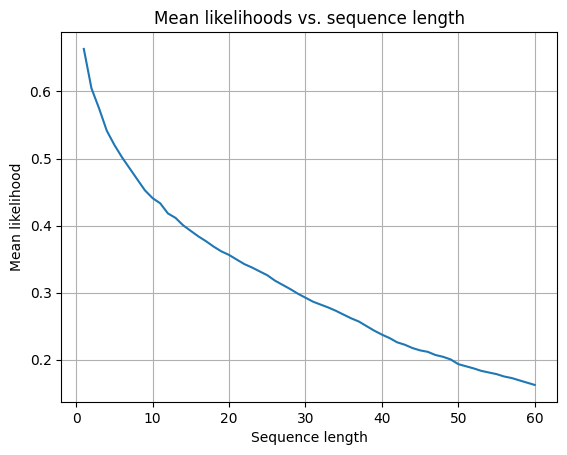

In [10]:
sample_length = 60
distributions = {"T" : T, "O" : O, "mu" : mu}
likelihoods = jax.vmap(lambda obs_seq: joint_likelihood(distributions, obs_seq))(observations[:, :sample_length])

plt.title("Mean likelihoods vs. sequence length")
plt.plot(jnp.arange(1, sample_length + 1), jnp.mean(likelihoods, axis=0))
plt.xlabel("Sequence length")
plt.ylabel("Mean likelihood")
plt.grid()
plt.show()

# Forward-Backward algorithm

The forward backward algorithm estimates the hidden parameters $T$ and $O$ of an HMM given a sequence of observations $o_1, \dots, o_T$ and the initial state distribution $\mu$.

It performs the following steps (assuming the initial state distribution $\mu$ is known):


1. Initialize $T, O$ in a smart way (otherwise might fail to converge)
2. **Expecatation step:**
    
    Compute $$\gamma_{t, j} = \frac{\alpha_{t,j} \beta_{t,j}}{p(o_1, \dots, o_T | T, O, \mu)}$$
    Compute $$\xi_{t, i, j} = \frac{\alpha_{t, i} T_{i,j} O_{j, o_{t+1}} \beta_{t +1, j}}{p(o_1, \dots, o_T | T, O, \mu)}$$

3. **Maximization step:**
    Compute new estimates of $T$ and $O$ in the following way:

    $$T_{i,j} = \frac{\sum_{t=1}^{T - 1} \xi_{t, i , j}}{\sum_{t=1}^{T - 1}\sum_{k=1}^{n} \xi_{t, i, k}}$$

    and

    $$O_{j, k} = \frac{\sum_{t=1, o_t = k}^T \gamma_{t, j}}{\sum_{t=1}^T \gamma_{t, j}}$$

4. If not converged, go to 2, else return $T$, $O$


The computation of $\alpha_{t,j}$ and $\beta_{t,j}$ work like this:

$$\alpha_{t, j} = \sum_{i=1}^n \alpha_{t-1, i} T_{i, j} O_{j, o_t} \Rightarrow \alpha_{t} = \alpha_{t-1} T \odot O_{:, o_t}$$

where $\alpha_1 = \mu \odot O_{:, o1}$. Also note that the likelihood of the entire sequence of observations $p(o_1, \dots, o_T | T, O, \mu)$ is given by

$$ p(o_1, \dots, o_T | T, O, \mu) = \sum_{i = 1}^n \alpha_{T, i} $$

For $\beta_t$:

$$\beta_{t, i} = \sum_{j = 1}^{n} T_{i,j} O_{j, o_{t+1}} \beta_{t +1} \Rightarrow \beta_{t} = T (O_{:, o_{t+1}} \odot \beta_{t + 1})$$

where $\beta_{T} = \mathbf{1}$ and also

$$ p(o_1, \dots, o_T | T, O, \mu) = \sum_{j = 1}^n \mu_j O_{j, o_1} \beta_{1, j} $$

The above formulas allow for a naive implementation of the algorithm.

Note that the calculation of $\gamma$ is an elementwise product of $\alpha$ and $\beta$, divided by the likelihood of the sequence (i.e. $\sum_j \alpha_{T,j}$)

Calculation of $\xi_t$ can be realized as so:

$$\xi_{t, i, j} = \frac{\alpha_{t, i} T_{i,j} O_{j, o_{t+1}} \beta_{t +1, j}}{p(o_1, \dots, o_T | T, O, \mu)}
\Rightarrow \xi_t = T \odot ( \alpha_t \cdot (O_{:, o_{t+1}} \odot \beta_{t + 1}))$$

where the product $\alpha_t \cdot (O_{:, o_{t+1}} \odot \beta_{t + 1})$ is the outer product, resulting in an $n \times n$ matrix.

In [11]:
import numpy as np

def forward_backward_naive(obs, mu, T_0, O_0, max_iter=50):
    t_max = len(obs)

    _T = np.array(T_0.copy())
    _O = np.array(O_0.copy())

    n, m = _O.shape

    for _ in range(max_iter):
        alpha = np.zeros((t_max, n))
        beta = np.ones((t_max, n))
        ovec = np.zeros((t_max, n))

        alpha[0] = mu @ _O[:, obs[0]]
        for t in range(1, t_max):
            alpha[t] = (alpha[t - 1] @ _T) * _O[:, obs[t]]
            ovec[t_max - t] = _O[:, obs[t_max - t]]
            beta[t_max - t - 1] = _T @ (ovec[t_max - t] * beta[t_max - t])

        likelihood = np.sum(alpha[t_max - 1])
        gamma = (alpha * beta) / likelihood

        xi = np.einsum("ij, ik->ijk", alpha[:-1], beta[1:] * ovec[1:])
        xi = xi * _T[None, ...]

        _T = np.sum(xi, axis=0) 
        _T = _T / np.sum(xi, axis=(0, -1))[..., None]

        for o in range(m):
            idx_filter = (obs == o)
            _O[:, o] = np.sum(gamma[idx_filter], axis=0)
        
        _O = _O / np.sum(gamma, axis=0)[..., None]
        

    return _T, _O

test_obs = observations[0, :100]

key, key_0, key_1 = jrng.split(key, 3)

_T, _O, = forward_backward_naive(test_obs, mu, jrng.uniform(key_0, T.shape), jrng.uniform(key_1, O.shape))

[1. 1. 1. 1.]
[1. 1. 1. 1.]


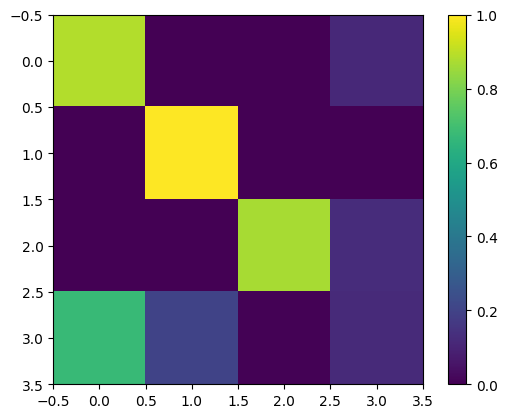

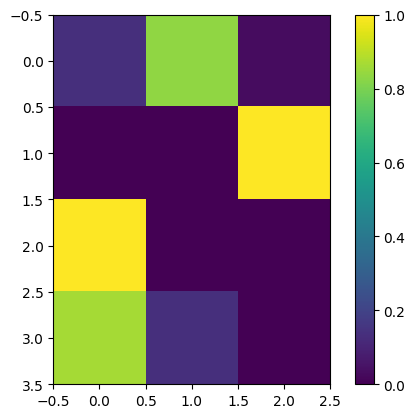

In [12]:
print(np.sum(_T, axis=-1))
print(np.sum(_O, axis=-1))

plt.imshow(_T)
plt.colorbar()
plt.show()
plt.imshow(_O)
plt.colorbar()
plt.show()

In [14]:
from tqdm import tqdm
n_trials = 10

T_arr = np.zeros((n_trials, n, n))
O_arr = np.zeros((n_trials, n, m))

for trial in tqdm(range(n_trials)):
    test_obs = observations[0, :200]

    key, key_0, key_1 = jrng.split(key, 3)

    T_arr[trial], O_arr[trial] = forward_backward_naive(test_obs, mu, np.triu(jrng.uniform(key_0, T.shape)), jrng.uniform(key_1, O.shape))

100%|██████████| 10/10 [00:17<00:00,  1.71s/it]


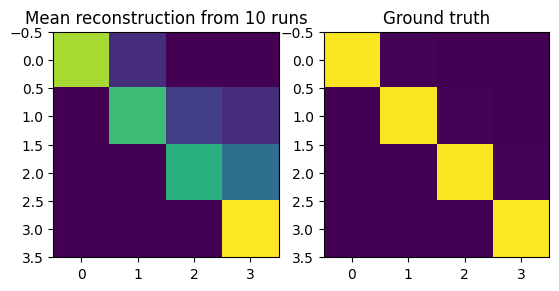

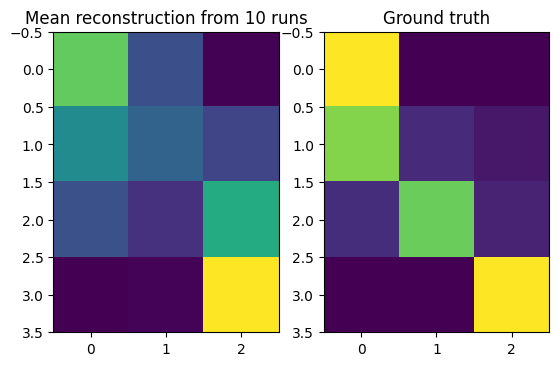

In [17]:
mean_T = np.mean(T_arr, axis=0)
mean_O = np.mean(O_arr, axis=0)

fig, ax = plt.subplots(1,2)
ax[0].imshow(mean_T)
ax[0].set_title(f"Mean reconstruction from {n_trials} runs")
ax[1].imshow(T)
ax[1].set_title("Ground truth")
plt.show()

fig, ax = plt.subplots(1,2)
ax[0].imshow(mean_O)
ax[0].set_title(f"Mean reconstruction from {n_trials} runs")
ax[1].imshow(O)
ax[1].set_title("Ground truth")
plt.show()

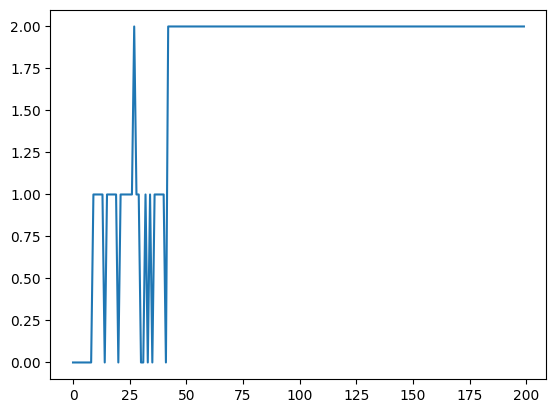

In [ ]:
plt.plot(test_obs)
plt.show()

In [18]:
reconstruction_result = jax.vmap(lambda _key: generate_sequence(_key, mean_T, mean_O, mu, len_sequence))(jnp.array(sequence_keys))

In [22]:
rec_states, rec_obs = reconstruction_result

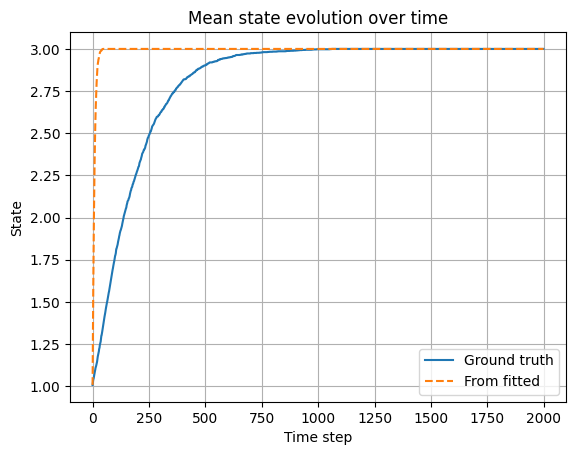

In [23]:
plt.title("Mean state evolution over time")
plt.plot(jnp.mean(states, axis=0), label="Ground truth")
plt.plot(jnp.mean(rec_states, axis=0), "--", label="From fitted")
plt.grid()
plt.xlabel("Time step")
plt.ylabel("State")
plt.legend()
plt.show()